In [1]:
import os
import sys

if os.environ['PY_SOURCES'] not in sys.path:
    sys.path.append(os.environ['PY_SOURCES'])

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext rpy2.ipython

In [2]:
import numpy as np
import pandas as pd
import kaggle.house_prices.helpers as helpers

combined_dataset = helpers.load_data()

In [4]:
%%R

library(dplyr)
library(ggplot2)

In [5]:
combined_dataset.shape
combined_dataset[combined_dataset['dataSource'] == 'train'].shape
combined_dataset[combined_dataset['dataSource'] == 'test'].shape

(2919, 82)

(1460, 82)

(1459, 82)

In [6]:
colnames = helpers.get_character_colnames(combined_dataset)
colnames.remove('dataSource')
colnames.append('SalePrice')

categ_data = combined_dataset[colnames]
categ_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 45 columns):
Alley            198 non-null object
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtQual         2838 non-null object
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      2918 non-null object
Exterior2nd      2918 non-null object
Fence            571 non-null object
FireplaceQu      1499 non-null object
Foundation       2919 non-null object
Functional       2917 non-null object
GarageCond       2760 non-null object
GarageFinish     2760 non-null object
GarageQual       2760 non-null object
GarageType       2762 non-null object
Heating          2919

In [7]:
colnames = helpers.get_numeric_colnames(combined_dataset)
colnames.remove('Id')

numeric_data = combined_dataset[colnames]
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 36 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
BedroomAbvGr     2919 non-null int64
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtUnfSF        2918 non-null float64
EnclosedPorch    2919 non-null int64
Fireplaces       2919 non-null int64
FullBath         2919 non-null int64
GarageArea       2918 non-null float64
GarageCars       2918 non-null float64
GarageYrBlt      2760 non-null float64
GrLivArea        2919 non-null int64
HalfBath         2919 non-null int64
KitchenAbvGr     2919 non-null int64
LotArea          2919 non-null int64
LotFrontage      2433 non-null float64
LowQualFinSF     2919 non-null int64
MasVnrArea       2896 non-null float64
MiscVal          2919 non-null int64
MoSold           2919 

In [8]:
def entropy(col):
    freqs = col.value_counts(dropna=False) / len(col)
    return -np.sum(freqs * np.log2(freqs))

In [12]:
categ_vars_by_entropy = (
    categ_data
    .drop('SalePrice', 1)
    .apply(entropy)
    .sort_values()
)
    
categ_vars_by_entropy.head(10)
categ_vars_by_entropy.tail()

Utilities      0.012627
PoolQC         0.038203
Street         0.038504
Condition2     0.106434
RoofMatl       0.138519
Heating        0.139775
MiscFeature    0.244488
LandSlope      0.303799
CentralAir     0.355183
Alley          0.423391
dtype: float64

BsmtFinType1    2.454724
Exterior1st     2.723429
Exterior2nd     2.800720
MSSubClass      2.920021
Neighborhood    4.212100
dtype: float64

In [13]:
numeric_vars_by_entropy = (
    numeric_data
    .drop('SalePrice', 1)
    .apply(entropy)
    .sort_values())
    
numeric_vars_by_entropy.head(10)
numeric_vars_by_entropy.tail()

PoolArea        0.057677
3SsnPorch       0.158769
LowQualFinSF    0.173265
KitchenAbvGr    0.280959
BsmtHalfBath    0.344808
MiscVal         0.374903
ScreenPorch     0.991907
HalfBath        1.010771
BsmtFullBath    1.077617
FullBath        1.173785
dtype: float64

TotalBsmtSF     9.348757
BsmtUnfSF       9.390885
1stFlrSF        9.601608
GrLivArea       9.882939
LotArea        10.400602
dtype: float64

In [14]:
xxx = pd.melt(
    (
        combined_dataset[['SalePrice']]
        .dropna()
        .rename(
            columns={"SalePrice": "price"}
        )
        .assign(
            **{
                'price.log': 
                lambda df: np.log(df.price)
              }
        )
    ), 
    var_name='var', 
    value_name='value'
).assign(
    normed_value = lambda df: (
        df.groupby('var', group_keys=False)
          .apply(
              lambda df: (df.value - np.mean(df.value)) / np.std(df.value)
          )
    )
)

(xxx
    .sort_values(['var', 'value'])
    .groupby('var')
    .tail(5)
)

,var,value,normed_value
803,price,582933.000000,5.062146
898,price,611657.000000,5.423840
1169,price,625000.000000,5.591855
1182,price,745000.000000,7.102899
691,price,755000.000000,7.228819
2263,price.log,13.275828,3.134810
2358,price.log,13.323927,3.255264
2629,price.log,13.345507,3.309307
2642,price.log,13.521139,3.749141
2151,price.log,13.534473,3.782532


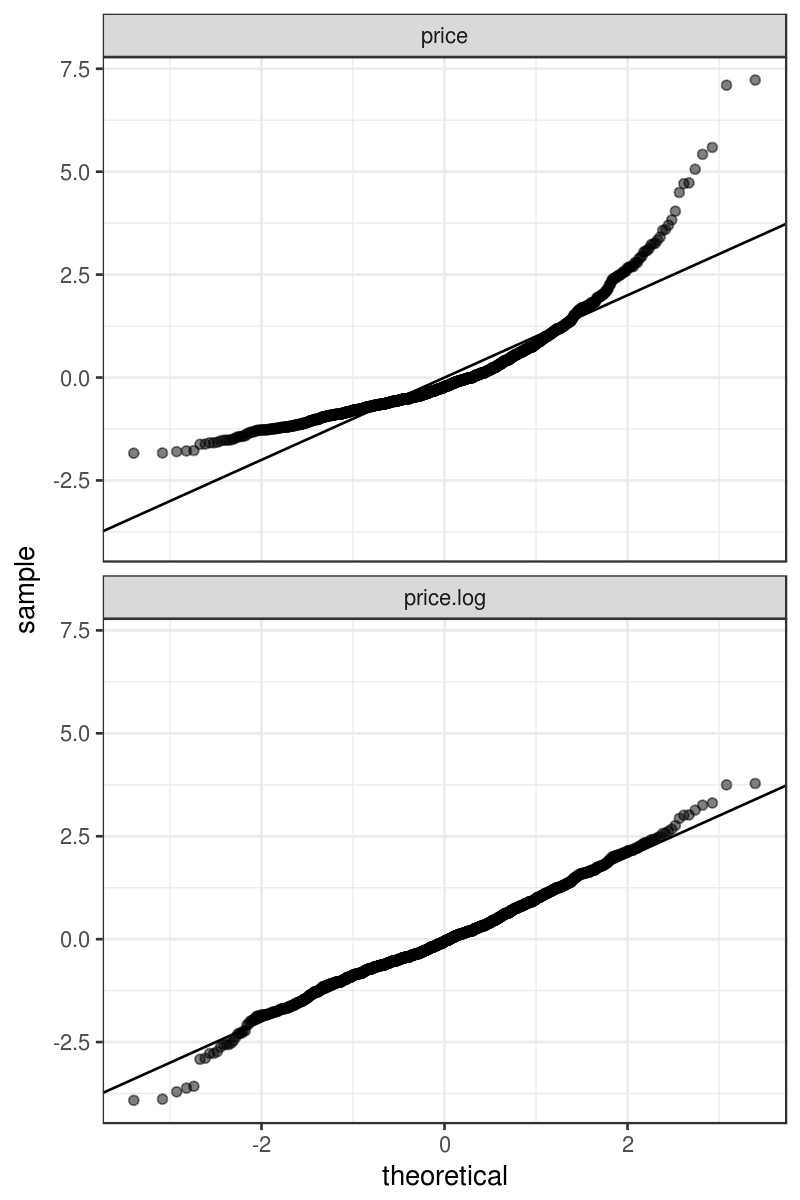

In [19]:
%%R -i xxx -w 800 -h 1200 -r 180

xxx %>%
group_by(var) %>%
mutate(
    normed_value = (value - mean(value)) / sd(value)
) %>%
ggplot() +
geom_qq(aes(sample=normed_value), alpha=0.5) +
facet_wrap(~var, ncol=1) +
geom_abline(slope=1) +
class categVarsVsTarget:theme_bw()

In [206]:
class CategVarsVsTarget:
    def __init__(self, categ_data):
        self.categ_data = categ_data
        self.long = None
        self.precalculated = None
    
    @staticmethod
    def calc_std(vec):
        if len(vec) == 1:
            return global_std
        if len(vec) > 1:
            return np.std(vec, ddof=1)
        
    @staticmethod    
    def calc_additive(df):
        up = (df['lead_mean'] - df['mean'])**2
        down = df['std']**2 / df['freq'] + df['lead_std']**2 / df['lead_freq']
        return up / down
    
    def get_long(self):
        if self.long:
            return self.long
        
        df = self.categ_data.dropna(subset=['SalePrice']).fillna('__missing__')
        
        self.long = pd.melt(
            frame=df, 
            id_vars=['SalePrice'], 
            var_name='var', 
            value_name='value'
        )
        return self.long
        
    def get_precalculated(self):
        """
            Pandas group by is not a friend with NaN. 
            So all NaNs are replaced with string `__missing__`.
        """
        if self.precalculated:
            return self.precalculated
        global_std = self.categ_data['SalePrice'].std()

        long = self.get_long().groupby(['var', 'value'])

        long = long.agg({
            'SalePrice': [('n',    np.count_nonzero), 
                          ('mean', np.mean), 
                          ('std',  lambda vec: self.calc_std(vec))]}
        )

        long.columns = long.columns.get_level_values(1)

        long = (long
                .assign(freq = long.groupby('var')['n'].apply(lambda n: n / np.sum(n)))
                .reset_index()
                .sort_values(['var', 'mean']))

        grp = long.groupby(['var'], group_keys=False)
        long['lead_mean'] = grp.apply(lambda df: df['mean'].shift(-1))
        long['lead_freq'] = grp.apply(lambda df: df['freq'].shift(-1))
        long['lead_std'] = grp.apply(lambda df: df['std'].shift(-1))
        
        self.precalculated = long
        return self.precalculated
    
    def get_separation(self):
        x = self.get_precalculated().assign(additive = self.calc_additive)
        x = x.groupby(['var'], group_keys=False)['additive'].sum().sort_values()
        return x


In [208]:
x = CategVarsVsTarget(categ_data).get_separation()
x.head(5)

var
Utilities     0.000205
LotConfig     0.000507
Functional    0.000648
PoolQC        0.001066
Condition2    0.001223
Name: additive, dtype: float64

In [210]:
x.tail(6)

var
BsmtFinType1    0.121116
CentralAir      0.204230
GarageFinish    0.275604
BsmtQual        0.421098
KitchenQual     0.477529
ExterQual       0.487153
Name: additive, dtype: float64

In [300]:
tmp = (
    categ_data
    .dropna(subset=['SalePrice'])
    [['SalePrice', 'ExterQual']]
    .fillna('__missing__')
)

factor_ordering = (
    tmp
    .groupby('ExterQual', as_index=False)
    .agg(np.mean)
    .sort_values('SalePrice')
    ['ExterQual']
)

tmp = (
    tmp
    .assign(ExterQual=(
        lambda df: df["ExterQual"]
                   .astype('category')
                   .cat.reorder_categories(factor_ordering, ordered=True)))
)

tmp.head()
tmp['ExterQual'].dtype

,SalePrice,ExterQual
0,208500.0,Gd
1,181500.0,TA
2,223500.0,Gd
3,140000.0,TA
4,250000.0,Gd


CategoricalDtype(categories=['Fa', 'TA', 'Gd', 'Ex'], ordered=True)

/home/me/opt/miniconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:61: UserWarning: Error while trying to convert the column "ExterQual". Fall back to string conversion. The error is: function takes at most 1 argument (2 given)
  (name, str(e)))


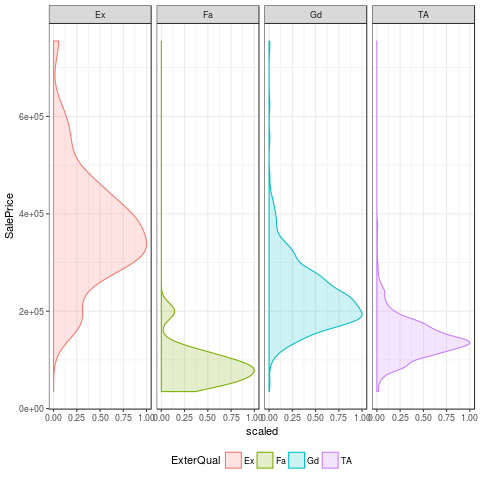

In [301]:
%%R -i tmp

tmp %>%
ggplot(aes(SalePrice, color=ExterQual)) +
geom_density(aes(y=..scaled.., fill=ExterQual), alpha=.2) +
facet_wrap(~ExterQual, nrow=1) +
coord_flip() +
theme_bw() +
theme(legend.position="bottom")